In [1]:
# 0. Load libraries #

import numpy as np
import pandas as pd
import os, time, warnings, random, gc, pickle, optuna
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

# Load custom pre-processing functions:

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()


def fillna_mp_i1(df_train, df_test, df_pred, num_features, cat_features, num_fill='median', cat_fill='mode'):
    """This function speeds up filling missing values for 3 main datasets using different imputation methods.
    Later may replace it with some subclass.
    Example: fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)"""
    # set df_pred to None if it does not exist
    if not ((cat_fill=='mode') and (num_fill=='median')):
        print ('Imputation method not Implemented yet!')
        return None
    
    df_train[num_features] = df_train[num_features].fillna(value=df_train[num_features].median())
    df_test[num_features] = df_test[num_features].fillna(value=df_train[num_features].median())
    df_train[cat_features] = df_train[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_test[cat_features] = df_test[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    if (df_pred is not None):
        df_pred[num_features] = df_pred[num_features].fillna(value=df_train[num_features].median())
        df_pred[cat_features] = df_pred[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_train[num_features+cat_features].count
    
    all_good = (
    (np.prod(df_train[num_features+cat_features].shape)==df_train[num_features+cat_features].count().sum()) and 
    (np.prod(df_test[num_features+cat_features].shape) == df_test[num_features+cat_features].count().sum()) and 
    (np.prod(df_pred[num_features+cat_features].shape) == df_pred[num_features+cat_features].count().sum()))
    if (all_good):
        print('Missing values imputed successfully')
    else:
        print('There are still some missing values...')
    
def add_misDummy_mp_i1(df_train, df_test, df_pred, features):
    """This function creates new dummy columns for missing features.
    Example: add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])"""
    # set df_pred to None if it does not exist
    for feature_name in features:
        misColName = 'mis'+feature_name
        df_train.loc[df_train[feature_name].isnull(), misColName]=1
        df_train.loc[df_train[feature_name].notnull(), misColName]=0
        df_test.loc[df_test[feature_name].isnull(), misColName]=1
        df_test.loc[df_test[feature_name].notnull(), misColName]=0
        if (df_pred is not None):
            df_pred.loc[df_pred[feature_name].isnull(), misColName]=1
            df_pred.loc[df_pred[feature_name].notnull(), misColName]=0
   

def discretize_mp_i1(df_train, df_test, df_pred, feature, ntiles, delete_feature=False):
    """This function divides a continuous feature into quantile groups.
    Example: discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)"""
    # set df_pred to None if it does not exist
    _,bin = pd.qcut(df_train[feature], ntiles, retbins = True, labels = False, duplicates = 'drop')
    df_train[feature+'Ntile'] = pd.cut(df_train[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    df_test[feature+'Ntile'] = pd.cut(df_test[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (df_pred is not None):
        df_pred[feature+'Ntile'] = pd.cut(df_pred[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (delete_feature==True):
        df_train.drop(columns=[feature], inplace=True)
        df_test.drop(columns=[feature], inplace=True)
        df_pred.drop(columns=[feature], inplace=True)
    print('Discretized ',feature, ' into ', len(bin)-1, ' bins')


def log_transformer_mp_i1(df_train, df_test, df_pred, feature_subset=False, min_skew=3):
    """This function divides a continuous feature into quantile groups.
    Example: log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)"""
    # set df_pred to None if it does not exist
    if (feature_subset==False):
        features_totransform = df_train.columns
    else:
        features_totransform = feature_subset.copy()
    skewed_vars = list(df_train.skew()[abs(df_train.skew())>min_skew].index)
    for col in list(set(skewed_vars)&set(features_totransform)):
        df_train[col] = np.log1p(df_train[col])
        df_test[col] = np.log1p(df_test[col])
        if (df_pred is not None):
            df_pred[col] = np.log1p(df_pred[col])
    print('Skewed columns log-transformed: ', list(set(skewed_vars)&set(features_totransform)))
    
    


In [2]:
time0 = time.time()
with open('../input/kp15-default-02downsampled/KP15_downsampled02.pickle', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df.sample(200000)
display(df.head(),df.shape)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
640401,93fb37f2381b41166a0c10fb9b31c70bf187e698adc67a...,2017-08-20,0.667602,0.274335,0.186295,0.025020,0.003453,0.211342,0.002084,0.558356,0.039405,0.062996,0.009288,0.149150,0.014214,0.012470,0.005790,0.472206,0.186347,0.093061,0.255096,0.027145,0.205246,1.001813,0.123506,0.007845,0.259884,0.102830,0.119552,0.429353,0.029987,NaN,0.099773,0.164849,0.006983,1.003981,0.001290,0.352925,0.044728,0.167823,0.033227,0.048407,0.082617,0.002284,0.196715,0.022117,0.157569,0.444005,0.830146,0.106837,0.002251,0.200341,0.042110,CO,O,0.009334,0.339052,1.004031,0.208727,0.502115,NaN,0.242711,6.0,0.287881,0.006105,0.423246,0.004196,0.004348,0.507541,0.254283,0.009752,0.001413,0.509747,0.176146,NaN,0.961452,0.079245,0.139522,NaN,0.005209,0.007966,NaN,0.279281,0.004709,0.000718,0.501091,0.004909,NaN,0.008359,0.000336,0.002621,0.508728,0.009709,0.008383,NaN,0.001541,1.001819,0.090081,0.003739,0.005523,0.005813,0.008680,0.008385,0.001876,NaN,1.0,0.008923,0.000363,NaN,0.004623,0.007157,NaN,1,0.003611,0.004667,0.000818,0.004331,0.005988,0.004871,0.002812,0.003321,0.002256,0.008477,0.003291,0.004723,0.002108,0.009638,0.007863,0.009376,0.009870,0.983068,0.135326,0.986469,0.974186,0.005994,0.954226,1.000992,0.968465,0.321294,0.355234,0.333867,0.001856,0.180240,0.000561,0.026686,5.0,NaN,0.008830,NaN,NaN,NaN,1.003312,1.914144,0.802798,0.009776,0.0,0.190218,0.0,2.0,0.184823,0.184199,0.0,0.244397,0.430842,0.008808,0.054808,0.005734,1.0,0.005071,1.000968,1.007980,0.000633,NaN,1.006024,0.978367,0.030836,0.083086,0.001200,NaN,NaN,NaN,NaN,NaN,0.001981,0.009966,0.003986,NaN,0.000490,0.000722,0.001176
323519,4a788efb5ebb1a16ec79ad8e02c1b148a786e4b84a16cb...,2017-09-28,0.577247,0.594215,0.049706,1.003103,0.003747,0.145762,0.007332,0.008578,NaN,0.002331,0.134882,0.336255,0.776885,0.045242,0.009342,0.445960,0.746547,0.522738,NaN,0.016107,0.355746,0.008336,NaN,0.000222,0.050292,0.204287,0.183063,0.607334,0.019171,NaN,0.023526,0.031486,0.001419,1.002693,0.002341,0.100924,0.027713,0.706851,0.551576,0.044523,0.033962,0.009882,0.326554,0.014195,0.032843,0.190083,0.042215,0.912729,0.008757,0.442845,0.330142,CO,O,0.003992,0.008970,NaN,0.528884,0.008321,NaN,0.008489,6.0,0.216947,0.007060,0.510458,0.001855,0.003333,0.003772,0.008966,0.032982,0.001434,0.206701,0.347521,NaN,0.002807,0.151109,0.133386,NaN,0.009048,0.003925,0.301477,0.047627,0.005212,0.004851,0.008607,0.003300,NaN,0.006815,0.009528,0.009931,0.502716,0.004409,0.001172,NaN,0.005686,1.006639,0.278113,0.008303,0.007778,0.001966,0.006623,0.006071,0.508652,NaN,0.0,0.000677,0.005982,NaN,0.002565,0.000181,NaN,1,0.006122,0.009922,0.008482,0.008368,0.008721,0.007591,1.007840,0.003296,0.004985,0.004189,0.008210,0.000425,0.005453,0.006063,0.009760,0.004248,0.000456,0.959695,0.139147,0.958613,0.974518,0.007529,0.006352,0.004794,0.000303,NaN,NaN,0.000833,0.008756,0.049764,NaN,1.009079,2.0,NaN,0.009223,NaN,NaN,NaN,1.002052,0.337239,0.195188,0.004530,1.0,0.270417,0.0,2.0,0.270600,0.261106,0.0,0.758888,0.572186,0.006637,0.185340,0.005765,1.0,0.002711,0.007012,0.004379,0.

(200000, 190)

In [3]:
df_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
display(len(df_labels))
df = pd.merge(df, df_labels, on='customer_ID', how='left')
display(df.shape, df.head())
df.drop(columns=['customer_ID', 'S_2'], inplace=True)

458913

(200000, 191)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,93fb37f2381b41166a0c10fb9b31c70bf187e698adc67a...,2017-08-20,0.667602,0.274335,0.186295,0.025020,0.003453,0.211342,0.002084,0.558356,0.039405,0.062996,0.009288,0.149150,0.014214,0.012470,0.005790,0.472206,0.186347,0.093061,0.255096,0.027145,0.205246,1.001813,0.123506,0.007845,0.259884,0.102830,0.119552,0.429353,0.029987,NaN,0.099773,0.164849,0.006983,1.003981,0.001290,0.352925,0.044728,0.167823,0.033227,0.048407,0.082617,0.002284,0.196715,0.022117,0.157569,0.444005,0.830146,0.106837,0.002251,0.200341,0.042110,CO,O,0.009334,0.339052,1.004031,0.208727,0.502115,NaN,0.242711,6.0,0.287881,0.006105,0.423246,0.004196,0.004348,0.507541,0.254283,0.009752,0.001413,0.509747,0.176146,NaN,0.961452,0.079245,0.139522,NaN,0.005209,0.007966,NaN,0.279281,0.004709,0.000718,0.501091,0.004909,NaN,0.008359,0.000336,0.002621,0.508728,0.009709,0.008383,NaN,0.001541,1.001819,0.090081,0.003739,0.005523,0.005813,0.008680,0.008385,0.001876,NaN,1.0,0.008923,0.000363,NaN,0.004623,0.007157,NaN,1,0.003611,0.004667,0.000818,0.004331,0.005988,0.004871,0.002812,0.003321,0.002256,0.008477,0.003291,0.004723,0.002108,0.009638,0.007863,0.009376,0.009870,0.983068,0.135326,0.986469,0.974186,0.005994,0.954226,1.000992,0.968465,0.321294,0.355234,0.333867,0.001856,0.180240,0.000561,0.026686,5.0,NaN,0.008830,NaN,NaN,NaN,1.003312,1.914144,0.802798,0.009776,0.0,0.190218,0.0,2.0,0.184823,0.184199,0.0,0.244397,0.430842,0.008808,0.054808,0.005734,1.0,0.005071,1.000968,1.007980,0.000633,NaN,1.006024,0.978367,0.030836,0.083086,0.001200,NaN,NaN,NaN,NaN,NaN,0.001981,0.009966,0.003986,NaN,0.000490,0.000722,0.001176,0
1,4a788efb5ebb1a16ec79ad8e02c1b148a786e4b84a16cb...,2017-09-28,0.577247,0.594215,0.049706,1.003103,0.003747,0.145762,0.007332,0.008578,NaN,0.002331,0.134882,0.336255,0.776885,0.045242,0.009342,0.445960,0.746547,0.522738,NaN,0.016107,0.355746,0.008336,NaN,0.000222,0.050292,0.204287,0.183063,0.607334,0.019171,NaN,0.023526,0.031486,0.001419,1.002693,0.002341,0.100924,0.027713,0.706851,0.551576,0.044523,0.033962,0.009882,0.326554,0.014195,0.032843,0.190083,0.042215,0.912729,0.008757,0.442845,0.330142,CO,O,0.003992,0.008970,NaN,0.528884,0.008321,NaN,0.008489,6.0,0.216947,0.007060,0.510458,0.001855,0.003333,0.003772,0.008966,0.032982,0.001434,0.206701,0.347521,NaN,0.002807,0.151109,0.133386,NaN,0.009048,0.003925,0.301477,0.047627,0.005212,0.004851,0.008607,0.003300,NaN,0.006815,0.009528,0.009931,0.502716,0.004409,0.001172,NaN,0.005686,1.006639,0.278113,0.008303,0.007778,0.001966,0.006623,0.006071,0.508652,NaN,0.0,0.000677,0.005982,NaN,0.002565,0.000181,NaN,1,0.006122,0.009922,0.008482,0.008368,0.008721,0.007591,1.007840,0.003296,0.004985,0.004189,0.008210,0.000425,0.005453,0.006063,0.009760,0.004248,0.000456,0.959695,0.139147,0.958613,0.974518,0.007529,0.006352,0.004794,0.000303,NaN,NaN,0.000833,0.008756,0.049764,NaN,1.009079,2.0,NaN,0.009223,NaN,NaN,NaN,1.002052,0.337239,0.195188,0.004530,1.0,0.270417,0.0,2.0,0.270600,0.261106,0.0,0.758888,0.572186,0.006637,0.185340,0.005765,1.0,0.002711,0.007012,0.004379,0.0

In [4]:
miss_c = df.count()
miss_feat = miss_c[miss_c<40000]
df = df[list(set(df.columns)-set(miss_feat.index))]
display(df.shape)
df[['D_114','D_120','D_68','B_30','D_117','D_116','B_38']] = \
df[['D_114','D_120','D_68','B_30','D_117','D_116','B_38']].apply(pd.to_numeric)
df['D_64'] = df['D_64'].astype('string')
display(df.dtypes)

(200000, 166)

D_64       string
D_129     float64
D_55      float64
D_58      float64
B_16      float64
D_68      float64
B_20      float64
R_6       float64
D_44      float64
D_45      float64
B_2       float64
R_20      float64
D_144     float64
B_4       float64
D_56      float64
D_115     float64
D_54      float64
S_8       float64
B_41      float64
D_93      float64
D_62      float64
B_17      float64
D_122     float64
D_128     float64
R_2       float64
D_51      float64
S_25      float64
R_4       float64
S_17      float64
D_86      float64
B_12      float64
B_37      float64
B_38      float64
R_25      float64
D_46      float64
S_19      float64
B_1       float64
D_105     float64
D_71      float64
D_125     float64
D_78      float64
S_23      float64
D_48      float64
B_9       float64
B_25      float64
D_79      float64
D_130     float64
S_20      float64
B_21      float64
D_131     float64
R_3       float64
D_133     float64
D_43      float64
D_83      float64
R_14      float64
D_145     

In [5]:
### sample split ###

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3))
display(train.dtypes, test.dtypes)


(180000, 166)

(20000, 166)

,D_64,D_129,D_55,D_58,B_16,D_68,B_20,R_6,D_44,D_45,B_2,R_20,D_144,B_4,D_56,D_115,D_54,S_8,B_41,D_93,D_62,B_17,D_122,D_128,R_2,D_51,S_25,R_4,S_17,D_86,B_12,B_37,B_38,R_25,D_46,S_19,B_1,D_105,D_71,D_125,D_78,S_23,D_48,B_9,B_25,D_79,D_130,S_20,B_21,D_131,R_3,D_133,D_43,D_83,R_14,D_145,B_28,D_126,D_96,S_24,R_5,S_16,B_19,S_5,B_22,R_10,D_124,P_4,R_23,D_114,D_118,D_39,B_15,B_11,D_109,B_27,D_123,R_11,D_63,D_53,D_60,S_26,target,S_3,S_6,R_8,D_113,R_22,P_2,D_82,R_17,D_139,D_143,D_140,B_7,S_12,R_19,D_59,D_112,D_94,D_72,B_33,R_16,D_69,B_36,B_10,R_27,D_81,S_7,D_103,B_13,S_22,S_11,D_80,D_127,D_41,B_24,D_52,D_92,R_7,B_8,B_30,B_40,R_18,D_102,D_119,B_6,D_61,P_3,R_13,S_15,D_50,R_12,R_28,D_75,S_18,D_47,S_27,R_15,D_89,R_1,B_14,D_74,D_70,D_121,B_23,B_32,R_24,R_21,B_26,D_91,B_31,D_104,D_77,D_116,D_107,D_117,D_141,D_65,S_13,D_84,B_3,B_18,B_5,D_120,S_9
0,O,1.007980,0.033227,0.196715,0.339052,6.0,0.242711,0.006105,0.009288,0.014214,0.025020,0.005988,0.000722,0.149150,0.048407,0.190218,1.003981,0.167823,0.000633,0.002108,0.042110,1.004031,0.430842,1.000968,0.005790,0.007845,0.974186,0.001290,0.001541,0.000363,0.044728,0.180240,5.0,0.009376,0.472206,0.003611,0.186295,0.321294,0.009752,0.005734,0.000718,0.135326,0.093061,0.259884,0.279281,0.501091,1.006024,0.004331,0.004196,0.978367,0.102830,0.083086,0.062996,0.005523,0.005813,0.001176,0.090081,1.0,0.009870,0.986469,0.002284,0.008359,0.502115,0.099773,0.507541,0.002621,0.054808,0.961452,0.008477,0.0,0.184823,0.274335,0.002251,0.164849,0.008830,0.009709,0.008808,0.508728,CO,NaN,0.830146,0.005994,0,0.211342,0.006983,0.004909,0.009776,0.002256,0.667602,NaN,0.004623,0.001981,0.000490,0.009966,0.205246,0.287881,0.004667,0.444005,1.003312,0.009638,0.001413,0.002812,0.001876,0.004348,0.001856,0.029987,0.026686,0.008383,0.352925,1.000992,0.082617,0.983068,0.200341,0.000336,0.005071,0.002084,0.005209,0.119552,0.004723,0.007966,1.001813,1.0,1.914144,0.007157,0.954226,0.184199,0.027145,0.106837,0.429353,0.003739,0.509747,0.123506,1.001819,0.001200,0.139522,0.008923,0.186347,0.802798,0.008680,0.003321,0.003453,0.157569,0.079245,0.254283,0.244397,0.176146,0.000818,0.007863,0.004871,0.004709,0.003291,1,0.968465,NaN,0.0,0.333867,2.0,0.003986,0.009334,0.423246,0.008385,0.558356,0.208727,0.012470,0.0,0.022117
1,O,0.004379,0.551576,0.326554,0.008970,6.0,0.008489,0.007060,0.134882,0.776885,1.003103,0.008721,0.008764,0.336255,0.044523,0.270417,1.002693,0.706851,0.008649,0.005453,0.330142,NaN,0.572186,0.007012,0.009342,0.000222,0.974518,0.002341,0.005686,0.005982,0.027713,0.049764,2.0,0.004248,0.445960,0.006122,0.049706,NaN,0.032982,0.005765,0.004851,0.139147,0.522738,0.050292,0.047627,0.008607,0.002392,0.008368,0.001855,0.005600,0.204287,0.000129,0.002331,0.007778,0.001966,0.003813,0.278113,1.0,0.000456,0.958613,0.009882,0.006815,0.008321,0.023526,0.003772,0.009931,0.185340,0.002807,0.004189,1.0,0.270600,0.594215,0.008757,0.031486,0.009223,0.004409,0.006637,0.502716,CO,NaN,0.042215,0.007529,0,0.145762,0.001419,0.003300,0.004530,0.004985,0.577247,NaN,0.002565,0.004608,0.004230,0.005002,0.355746,0.216947,0.009922,0.190083,1.002052,0.006063,0.001434,1.007840,0.508652,0.003333,0.008756,0.019171,1.009079,0.001172,0.100924,0.004794,0.033962,0.959695,0.442845,0.009528,0.002711,0.007332,0.009048,0.183063,0.000425,0.003925,0.008336,0.0,0.337239,0.000181,0.006352,0.261106,0.016107,0.912729,0.607334,0.008303,0.206701,NaN,1.006639,0.001807,0.133386,0.000677,0.746547,0.195188,0.006623,0.003296,0.003747,0.032843,0.151109,0.008966,0.758888,0.347521,0.008482,0.009760,0.007591,0.005212,0.008210,1,0.000303,0.301477,0.0,0.000833,2.0,0.001715,0.003992,0.510458,0.006071,0.008578,0.528884,0.045242,0.0,0.014195
2,R,1.001618,0.595346,0.681779,1.005054,5.0,1.002314,0.012212,0.382693,0.156116,0.036814,0.003222,0.178808,1.094046,0.126681,0.071534,1.008348,0.707376,0.009767,0.006916,0.273408,0.985971,0.149466,1.006480,1.007617,0.005183,0.976124,1.008698,0.001058,0.005847,0.080234,0.328019,3.0,0.009022,0.732475,0.002723,0.327496,0.363922,0.000760,0.0088

,D_64,D_129,D_55,D_58,B_16,D_68,B_20,R_6,D_44,D_45,B_2,R_20,D_144,B_4,D_56,D_115,D_54,S_8,B_41,D_93,D_62,B_17,D_122,D_128,R_2,D_51,S_25,R_4,S_17,D_86,B_12,B_37,B_38,R_25,D_46,S_19,B_1,D_105,D_71,D_125,D_78,S_23,D_48,B_9,B_25,D_79,D_130,S_20,B_21,D_131,R_3,D_133,D_43,D_83,R_14,D_145,B_28,D_126,D_96,S_24,R_5,S_16,B_19,S_5,B_22,R_10,D_124,P_4,R_23,D_114,D_118,D_39,B_15,B_11,D_109,B_27,D_123,R_11,D_63,D_53,D_60,S_26,target,S_3,S_6,R_8,D_113,R_22,P_2,D_82,R_17,D_139,D_143,D_140,B_7,S_12,R_19,D_59,D_112,D_94,D_72,B_33,R_16,D_69,B_36,B_10,R_27,D_81,S_7,D_103,B_13,S_22,S_11,D_80,D_127,D_41,B_24,D_52,D_92,R_7,B_8,B_30,B_40,R_18,D_102,D_119,B_6,D_61,P_3,R_13,S_15,D_50,R_12,R_28,D_75,S_18,D_47,S_27,R_15,D_89,R_1,B_14,D_74,D_70,D_121,B_23,B_32,R_24,R_21,B_26,D_91,B_31,D_104,D_77,D_116,D_107,D_117,D_141,D_65,S_13,D_84,B_3,B_18,B_5,D_120,S_9
88729,O,0.003057,0.111457,0.002376,0.009862,6.0,0.002492,0.008344,0.002261,0.444209,1.000075,0.007826,0.000706,0.160355,NaN,0.229342,1.007597,1.009197,0.006691,0.003452,0.761634,NaN,0.575176,0.000028,0.001170,0.673774,0.976640,0.000807,0.009597,1.008228,2.350039,0.018459,2.0,0.000856,0.674816,0.008569,0.026831,NaN,0.402110,0.002506,0.005706,0.132091,0.155899,0.006920,0.008285,0.001745,0.005358,0.004644,0.009377,0.009643,0.305998,0.004605,0.684893,0.007774,0.001237,0.007509,0.576799,1.0,1.004628,0.965470,0.001643,0.000030,0.007633,0.009828,0.004662,0.002694,0.687900,0.004315,0.009828,1.0,0.430792,0.000203,0.956352,0.019813,0.009882,0.000505,0.000373,0.506342,CR,0.004769,0.655807,21.140829,0,-0.101312,0.005363,0.005278,0.002550,0.007303,0.506366,0.508818,0.002645,0.004828,0.009080,0.003647,0.026307,0.241040,0.004336,0.022062,1.005489,0.003759,0.001728,1.000954,0.509386,0.005181,0.004379,0.295350,1.008765,0.003790,-0.078868,0.004253,2.699883,0.957684,1.487590,0.204921,0.006097,0.002212,0.001832,0.356311,1.004185,0.005767,0.003887,0.0,0.056095,0.009745,0.006989,0.369062,0.189027,0.042730,0.243838,0.004721,0.107803,NaN,1.000448,0.007625,0.007605,1.002588,0.682483,0.255122,0.004267,0.001597,0.009598,0.812508,0.005818,0.009439,0.692342,0.019017,0.002108,0.009461,0.000600,0.005965,0.505783,1,0.001366,0.706190,0.0,0.007342,-1.0,0.000554,0.006697,1.007731,0.003526,0.004298,1.003175,2.368506,0.0,0.015261
16865,R,0.006875,0.024771,0.083876,0.833685,3.0,0.589129,0.000585,0.002023,0.032506,0.015857,0.009754,0.386775,0.154214,NaN,0.029423,1.000417,0.174555,0.000434,0.005060,0.031516,NaN,0.432820,0.009680,0.004806,0.002531,0.969391,0.002503,0.007294,0.004267,0.006700,0.481542,4.0,0.003497,NaN,0.002022,0.479205,0.411139,0.007936,0.007092,0.009971,0.140409,NaN,0.405233,0.191173,0.007425,0.009620,0.009847,0.003188,0.003529,0.109622,0.006434,0.057396,0.005896,0.001372,0.367257,0.059928,1.0,0.005486,0.967148,0.005455,0.004485,0.703291,0.211027,0.502979,0.006672,0.186123,0.005339,0.008104,0.0,0.023414,0.008027,0.003034,0.430594,0.001781,0.009831,0.003610,0.003071,CO,NaN,0.914326,0.006207,0,0.202479,0.001029,0.002985,0.805185,0.004340,0.728934,NaN,0.007110,1.000806,1.002600,0.005676,0.222410,0.187035,0.002303,0.440120,1.001642,0.004763,0.006119,0.005230,0.006266,0.007567,0.002464,0.007924,1.009529,0.001168,0.344481,1.000453,0.031642,0.962347,0.366436,0.004424,0.008196,0.001189,0.007516,0.053720,0.000850,0.006572,1.005275,1.0,0.029241,0.005299,0.390756,0.028111,0.015664,0.058173,0.818783,0.004372,0.500603,NaN,1.003947,0.001453,0.138883,0.001163,0.092952,0.672169,0.006235,0.002323,0.004623,0.116291,0.076336,0.007147,0.136013,0.175349,0.009236,0.009835,0.001741,0.006129,0.000587,1,0.977126,NaN,0.0,0.337916,1.0,0.875996,0.008303,0.428621,0.008066,0.285409,0.214094,0.006896,0.0,0.061923
89041,O,0.008640,0.066120,0.002233,0.085665,6.0,0.008110,0.001404,0.002410,0.367018,0.818741,0.009356,0.003745,0.031700,NaN,0.497709,1.008713,0.491894,0.002256,0.006961,0.066986,NaN,0.574950,0.006076,0.006081,0.002158,0.977528,0.005723,0.004175,0.003880,0.028589,0.077034,2.0,0.000491,0.422592,0.001734,0.071717,NaN,0.243937,0.007499,0.009502,0.13840

D_64       string
D_129     float64
D_55      float64
D_58      float64
B_16      float64
D_68      float64
B_20      float64
R_6       float64
D_44      float64
D_45      float64
B_2       float64
R_20      float64
D_144     float64
B_4       float64
D_56      float64
D_115     float64
D_54      float64
S_8       float64
B_41      float64
D_93      float64
D_62      float64
B_17      float64
D_122     float64
D_128     float64
R_2       float64
D_51      float64
S_25      float64
R_4       float64
S_17      float64
D_86      float64
B_12      float64
B_37      float64
B_38      float64
R_25      float64
D_46      float64
S_19      float64
B_1       float64
D_105     float64
D_71      float64
D_125     float64
D_78      float64
S_23      float64
D_48      float64
B_9       float64
B_25      float64
D_79      float64
D_130     float64
S_20      float64
B_21      float64
D_131     float64
R_3       float64
D_133     float64
D_43      float64
D_83      float64
R_14      float64
D_145     

D_64       string
D_129     float64
D_55      float64
D_58      float64
B_16      float64
D_68      float64
B_20      float64
R_6       float64
D_44      float64
D_45      float64
B_2       float64
R_20      float64
D_144     float64
B_4       float64
D_56      float64
D_115     float64
D_54      float64
S_8       float64
B_41      float64
D_93      float64
D_62      float64
B_17      float64
D_122     float64
D_128     float64
R_2       float64
D_51      float64
S_25      float64
R_4       float64
S_17      float64
D_86      float64
B_12      float64
B_37      float64
B_38      float64
R_25      float64
D_46      float64
S_19      float64
B_1       float64
D_105     float64
D_71      float64
D_125     float64
D_78      float64
S_23      float64
D_48      float64
B_9       float64
B_25      float64
D_79      float64
D_130     float64
S_20      float64
B_21      float64
D_131     float64
R_3       float64
D_133     float64
D_43      float64
D_83      float64
R_14      float64
D_145     

In [6]:
cat_feat = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']
num_feat = list(set(train.columns)-set(cat_feat)-set(['target']))
display(train[cat_feat], [train[col].value_counts() for col in train.columns if col in cat_feat])

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
0,1.0,5.0,0.0,0.0,2.0,0.0,1.0,CO,O,6.0
1,0.0,2.0,1.0,0.0,2.0,0.0,1.0,CO,O,6.0
2,1.0,3.0,1.0,0.0,-1.0,0.0,1.0,CO,R,5.0
3,0.0,2.0,0.0,0.0,4.0,0.0,1.0,CR,R,6.0
4,0.0,1.0,NaN,NaN,NaN,NaN,NaN,CO,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...
199994,0.0,3.0,0.0,0.0,3.0,0.0,1.0,CO,O,6.0
199995,2.0,4.0,1.0,0.0,2.0,1.0,1.0,CO,O,3.0
199996,0.0,3.0,0.0,0.0,-1.0,0.0,1.0,CO,U,1.0
199997,0.0,1.0,1.0,0.0,5.0,0.0,1.0,CO,O,5.0


[O     94638
 U     49775
 R     27223
 -1     1250
 Name: D_64, dtype: Int64,
 6.0    90339
 5.0    39142
 3.0    15847
 4.0    15513
 2.0     7095
 1.0     4501
 0.0      513
 Name: D_68, dtype: int64,
 2.0    63561
 3.0    40572
 1.0    37695
 5.0    14470
 4.0     9676
 7.0     8481
 6.0     5481
 Name: B_38, dtype: int64,
  1.0    139067
  0.0     28787
 -1.0      8379
 Name: D_126, dtype: int64,
 1.0    108065
 0.0     66245
 Name: D_114, dtype: int64,
 CO    134095
 CR     30229
 CL     14234
 XZ       872
 XM       372
 XL       198
 Name: D_63, dtype: int64,
 0.0    153145
 1.0     24998
 2.0      1793
 Name: B_30, dtype: int64,
 0.0    174115
 1.0       195
 Name: D_116, dtype: int64,
 -1.0    47589
  3.0    38176
  4.0    37003
  2.0    21589
  5.0    14705
  6.0    11222
  1.0     4026
 Name: D_117, dtype: int64,
 0.0    153860
 1.0     20450
 Name: D_120, dtype: int64]

In [7]:
for col in cat_feat:
    if train[col].dtype in ['string', 'O', 'str']:
        print('str', col)
    else:
        print('num', col)
        

num B_30
num B_38
num D_114
num D_116
num D_117
num D_120
num D_126
str D_63
str D_64
num D_68


In [8]:
### fill missing values ###

for col in cat_feat:
    if train[col].dtype in ['string', 'O', 'str']:
        train[col].fillna(value='M', inplace=True)
        test[col].fillna(value='M', inplace=True)
    else:
        train[col].fillna(value=-1000, inplace=True)
        test[col].fillna(value=-1000, inplace=True)

for col in num_feat:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(train[col].median(), inplace=True)
    
display(train.count(), test.count())

D_64      180000
D_129     180000
D_55      180000
D_58      180000
B_16      180000
D_68      180000
B_20      180000
R_6       180000
D_44      180000
D_45      180000
B_2       180000
R_20      180000
D_144     180000
B_4       180000
D_56      180000
D_115     180000
D_54      180000
S_8       180000
B_41      180000
D_93      180000
D_62      180000
B_17      180000
D_122     180000
D_128     180000
R_2       180000
D_51      180000
S_25      180000
R_4       180000
S_17      180000
D_86      180000
B_12      180000
B_37      180000
B_38      180000
R_25      180000
D_46      180000
S_19      180000
B_1       180000
D_105     180000
D_71      180000
D_125     180000
D_78      180000
S_23      180000
D_48      180000
B_9       180000
B_25      180000
D_79      180000
D_130     180000
S_20      180000
B_21      180000
D_131     180000
R_3       180000
D_133     180000
D_43      180000
D_83      180000
R_14      180000
D_145     180000
B_28      180000
D_126     180000
D_96      1800

D_64      20000
D_129     20000
D_55      20000
D_58      20000
B_16      20000
D_68      20000
B_20      20000
R_6       20000
D_44      20000
D_45      20000
B_2       20000
R_20      20000
D_144     20000
B_4       20000
D_56      20000
D_115     20000
D_54      20000
S_8       20000
B_41      20000
D_93      20000
D_62      20000
B_17      20000
D_122     20000
D_128     20000
R_2       20000
D_51      20000
S_25      20000
R_4       20000
S_17      20000
D_86      20000
B_12      20000
B_37      20000
B_38      20000
R_25      20000
D_46      20000
S_19      20000
B_1       20000
D_105     20000
D_71      20000
D_125     20000
D_78      20000
S_23      20000
D_48      20000
B_9       20000
B_25      20000
D_79      20000
D_130     20000
S_20      20000
B_21      20000
D_131     20000
R_3       20000
D_133     20000
D_43      20000
D_83      20000
R_14      20000
D_145     20000
B_28      20000
D_126     20000
D_96      20000
S_24      20000
R_5       20000
S_16      20000
B_19    

In [9]:
### OHE ###

X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())
#display(X_train.nunique())

### Do OHE for some features ###

# this code uses passthrough from 
# https://stackoverflow.com/questions/54160370/how-to-use-sklearn-column-transformer

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_feat)],
    remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())

print('time to do feature proprocessing: ', time.time()-time0)

print('Number of features after transaformation: ', X_train.shape)

,D_64,D_129,D_55,D_58,B_16,D_68,B_20,R_6,D_44,D_45,B_2,R_20,D_144,B_4,D_56,D_115,D_54,S_8,B_41,D_93,D_62,B_17,D_122,D_128,R_2,D_51,S_25,R_4,S_17,D_86,B_12,B_37,B_38,R_25,D_46,S_19,B_1,D_105,D_71,D_125,D_78,S_23,D_48,B_9,B_25,D_79,D_130,S_20,B_21,D_131,R_3,D_133,D_43,D_83,R_14,D_145,B_28,D_126,D_96,S_24,R_5,S_16,B_19,S_5,B_22,R_10,D_124,P_4,R_23,D_114,D_118,D_39,B_15,B_11,D_109,B_27,D_123,R_11,D_63,D_53,D_60,S_26,S_3,S_6,R_8,D_113,R_22,P_2,D_82,R_17,D_139,D_143,D_140,B_7,S_12,R_19,D_59,D_112,D_94,D_72,B_33,R_16,D_69,B_36,B_10,R_27,D_81,S_7,D_103,B_13,S_22,S_11,D_80,D_127,D_41,B_24,D_52,D_92,R_7,B_8,B_30,B_40,R_18,D_102,D_119,B_6,D_61,P_3,R_13,S_15,D_50,R_12,R_28,D_75,S_18,D_47,S_27,R_15,D_89,R_1,B_14,D_74,D_70,D_121,B_23,B_32,R_24,R_21,B_26,D_91,B_31,D_104,D_77,D_116,D_107,D_117,D_141,D_65,S_13,D_84,B_3,B_18,B_5,D_120,S_9
88729,O,0.003057,0.111457,0.002376,0.009862,6.0,0.002492,0.008344,0.002261,0.444209,1.000075,0.007826,0.000706,0.160355,0.148488,0.229342,1.007597,1.009197,0.006691,0.003452,0.761634,0.933030,0.575176,0.000028,0.001170,0.673774,0.976640,0.000807,0.009597,1.008228,2.350039,0.018459,2.0,0.000856,0.674816,0.008569,0.026831,0.334126,0.402110,0.002506,0.005706,0.132091,0.155899,0.006920,0.008285,0.001745,0.005358,0.004644,0.009377,0.009643,0.305998,0.004605,0.684893,0.007774,0.001237,0.007509,0.576799,1.0,1.004628,0.965470,0.001643,0.000030,0.007633,0.009828,0.004662,0.002694,0.687900,0.004315,0.009828,1.0,0.430792,0.000203,0.956352,0.019813,0.009882,0.000505,0.000373,0.506342,CR,0.004769,0.655807,21.140829,-0.101312,0.005363,0.005278,0.002550,0.007303,0.506366,0.508818,0.002645,0.004828,0.009080,0.003647,0.026307,0.241040,0.004336,0.022062,1.005489,0.003759,0.001728,1.000954,0.509386,0.005181,0.004379,0.295350,1.008765,0.003790,-0.078868,0.004253,2.699883,0.957684,1.487590,0.204921,0.006097,0.002212,0.001832,0.356311,1.004185,0.005767,0.003887,0.0,0.056095,0.009745,0.006989,0.369062,0.189027,0.042730,0.243838,0.004721,0.107803,0.109491,1.000448,0.007625,0.007605,1.002588,0.682483,0.255122,0.004267,0.001597,0.009598,0.812508,0.005818,0.009439,0.692342,0.019017,0.002108,0.009461,0.000600,0.005965,0.505783,1,0.001366,0.706190,0.0,0.007342,-1.0,0.000554,0.006697,1.007731,0.003526,0.004298,1.003175,2.368506,0.0,0.015261
16865,R,0.006875,0.024771,0.083876,0.833685,3.0,0.589129,0.000585,0.002023,0.032506,0.015857,0.009754,0.386775,0.154214,0.148488,0.029423,1.000417,0.174555,0.000434,0.005060,0.031516,0.933030,0.432820,0.009680,0.004806,0.002531,0.969391,0.002503,0.007294,0.004267,0.006700,0.481542,4.0,0.003497,0.459584,0.002022,0.479205,0.411139,0.007936,0.007092,0.009971,0.140409,0.286427,0.405233,0.191173,0.007425,0.009620,0.009847,0.003188,0.003529,0.109622,0.006434,0.057396,0.005896,0.001372,0.367257,0.059928,1.0,0.005486,0.967148,0.005455,0.004485,0.703291,0.211027,0.502979,0.006672,0.186123,0.005339,0.008104,0.0,0.023414,0.008027,0.003034,0.430594,0.001781,0.009831,0.003610,0.003071,CO,0.013650,0.914326,0.006207,0.202479,0.001029,0.002985,0.805185,0.004340,0.728934,0.504429,0.007110,1.000806,1.002600,0.005676,0.222410,0.187035,0.002303,0.440120,1.001642,0.004763,0.006119,0.005230,0.006266,0.007567,0.002464,0.007924,1.009529,0.001168,0.344481,1.000453,0.031642,0.962347,0.366436,0.004424,0.008196,0.001189,0.007516,0.053720,0.000850,0.006572,1.005275,1.0,0.029241,0.005299,0.390756,0.028111,0.015664,0.058173,0.818783,0.004372,0.500603,0.109491,1.003947,0.001453,0.138883,0.001163,0.092952,0.672169,0.006235,0.002323,0.004623,0.116291,0.076336,0.007147,0.136013,0.175349,0.009236,0.009835,0.001741,0.006129,0.000587,1,0.977126,0.205845,0.0,0.337916,1.0,0.875996,0.008303,0.428621,0.008066,0.285409,0.214094,0.006896,0.0,0.061923
89041,O,0.008640,0.066120,0.002233,0.085665,6.0,0.008110,0.001404,0.002410,0.367018,0.818741,0.009356,0.003745,0.031700,0.148488,0.497709,1.008713,0.491894,0.002256,0.006961,0.066986,0.933030,0.574950,0.006076,0.006081,0.002158,0.977528,0.005723,0.004175,0.003880,0.028589,0.077034,2.0,0.000491,0.4225

Number of features before transaformation:  (180000, 165)
time to do feature proprocessing:  21.52031922340393
Number of features after transaformation:  (180000, 207)


In [10]:
# Modeling #

xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators=500, eta=0.03)
xgb.fit(X_train, y_train)

display('Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
#display('Recall score: ', recall_score(y_train,xgb.predict(X_train)))
#display('Precision score: ', precision_score(y_train,xgb.predict(X_train)))
display('ROC score: ', roc_auc_score(y_train,xgb.predict(X_train)))

# Performance evaluation:
display('Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
#display('Recall score: ', recall_score(y_test,xgb.predict(X_test)))
#display('Precision score: ', precision_score(y_test,xgb.predict(X_test)))
display('ROC score: ', roc_auc_score(y_test,xgb.predict(X_test)))

'Accuracy: '

0.8994

'F1 score: '

0.7973090957935033

'ROC score: '

0.8640575380806286

'Accuracy: '

0.87585

'F1 score: '

0.7487604978245472

'ROC score: '

0.8329542021817561

[I 2022-07-31 19:18:00,885] A new study created in memory with name: no-name-0babb94c-12e9-4db3-b817-a37cb7ae6f93
[I 2022-07-31 19:18:08,664] Trial 0 finished with value: 0.8274089500163055 and parameters: {'n_estimators': 379, 'max_depth': 3, 'learning_rate': 0.050148143027367316, 'colsample_bytree': 0.3073176112367019, 'subsample': 0.563270005497353, 'alpha': 0.9355957074380796, 'lambda': 0.7948988059333746, 'gamma': 1.673440740542746e-07, 'min_child_weight': 0.6874183910327237}. Best is trial 0 with value: 0.8274089500163055.
[I 2022-07-31 19:18:17,553] Trial 1 finished with value: 0.8215121516069693 and parameters: {'n_estimators': 689, 'max_depth': 2, 'learning_rate': 0.026266595809140925, 'colsample_bytree': 0.29486691135296383, 'subsample': 0.5443772768003964, 'alpha': 0.10962253780383066, 'lambda': 18.38373842476329, 'gamma': 0.02274678735519054, 'min_child_weight': 4.008890269695546}. Best is trial 0 with value: 0.8274089500163055.
[I 2022-07-31 19:18:39,078] Trial 2 finished 

Total time for hypermarameter optimization  1101.1918914318085
        n_estimators : 666
           max_depth : 8
       learning_rate : 0.0256143702888407
    colsample_bytree : 0.8195294895716614
           subsample : 0.7423234814595562
               alpha : 1.4037047925131176
              lambda : 144.28606248236792
               gamma : 2.6785901258009413e-10
    min_child_weight : 0.22698443323187917
best objective value : 0.833869062318937


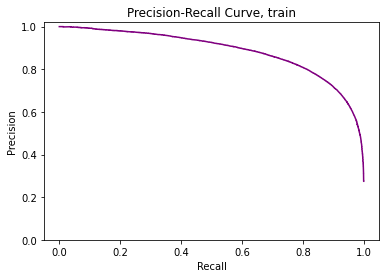

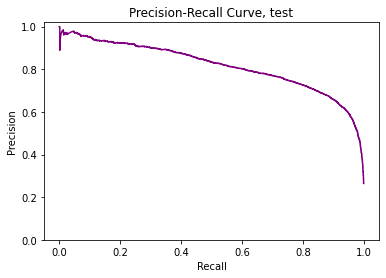

'Accuracy: '

0.9029388888888888

'F1 score: '

0.8048129238400609

'ROC score: '

0.8694206259122413

'Accuracy: '

0.8759

'F1 score: '

0.7494447809408439

'ROC score: '

0.8338019522762938

Total time for the whole script:  1191.1490333080292 
 Time for the modeling part:  1149.0183019638062


In [11]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, n_splits=2, n_jobs=-1, scale_pos_weight=1, early_stopping_rounds=50):

    cv_regularizer=0.0
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }

    X = X_train
    y = y_train

    model = XGBClassifier(**params)
    rkf = KFold(n_splits=n_splits, shuffle=True)
    X_values = X.values
    y_values = y.values
    y_pred = np.zeros_like(y_values)
    y_pred_train = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(X_A, y_A, eval_set=[(X_B, y_B)],
                  early_stopping_rounds=early_stopping_rounds, verbose = False)
        y_pred[test_index] += model.predict(X_B)
        y_pred_train[train_index] += model.predict(X_A)
    score_train = roc_auc_score(y_train, y_pred_train)
    score_test = roc_auc_score(y_train, y_pred) 
    overfit = score_train-score_test
    #return (f1_score_test)
    return (score_test-cv_regularizer*overfit)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1
#optuna_hyperpars['early_stopping_rounds']=50

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

y_score = optuna_xgb.predict_proba(X_test)[:, 1]

# pr in train set
precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

# pr in test set
precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall_test = auc(recall, precision)
temp = recall[(recall>0.195)&(recall<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall==temp)))[0][0]
r20prec_test = precision[indexx]

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()


display('Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROC score: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
#display('Recall score: ', recall_score(y_train,optuna_xgb.predict(X_train)))
#display('Precision score: ', precision_score(y_train,optuna_xgb.predict(X_train)))
#display('Precision at 20% recall: ', r20prec_train)
# Performance evaluation:
display('Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROC score: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
#display('Recall score: ', recall_score(y_test,optuna_xgb.predict(X_test)))
#display('Precision score: ', precision_score(y_test,optuna_xgb.predict(X_test)))
#display('PRUC: ', auc_precision_recall_test)
#display('Precision at 20% recall: ', r20prec_test)

print('Total time for the whole script: ', time.time()-time0, '\n',
     'Time for the modeling part: ', time.time()-time1)

In [12]:
#submission_df_bt = pd.DataFrame({'Id': pred.Id, 'SalePrice': xgbm3.predict(X_pred[cols_veryveryfew])}, columns=['Id', 'SalePrice'])

#submission_df_bt.to_csv('KP20_bt.csv',index=False)

#os.chdir(r'/kaggle/working')

#from IPython.display import FileLink
#FileLink(r'KP20_bt.csv')

In [13]:
#df = pd.read_csv('../input/amex-default-prediction/train_data.csv', skiprows=lambda i: i>0 and random.random() > 0.2)
#display(df.shape)

#with open('KP15_downsampled02.pickle', 'wb') as f:
#    pickle.dump(df, f)
